In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import correlate
from pulse_pair_doppler import chirp, pulse_pairs, random_receive, delayed_correlation

In [349]:
# TODO module surface with corresponding reflection, rather than instantly a reflection

# NOTE for few reflectors, the phase difference after pulse compression is approx 0
#      Adding more reflecors quickly results in a significant phase difference
#      Tapering reduces this noise phase but only up to a certain point

# add random phase to scatterers uniform
# average pixels from pulse pair
# start from negative half bandwith
# one scatter per pixel???

T0 = 0e-4 # s
Te = 1e-4 # s
B_c = 1e6 # hz
f =  0 #5.405e9 # hz
c = 3e8 # m/s
Lambda = 0.05 #c/f # m
over_sample = 10 # -
downsample_factor = 10
receive_time = 20e-4 # Te*10
n_reflectors = 100000 #
T_interpulse = 0 # s (Te-T0)/4
n_pulses = 2 # -

T_pulse = Te-T0 # s
k_c = B_c/Te # hz/s
fs_nyq = 2 * (f + B_c)  # hz, times 2 to follow Nyquist
fs = fs_nyq * over_sample # hz
s = 1/fs # stepsize
t = np.arange(T0, (Te) - s, s) # s
receive_samples = int(receive_time*fs )

In [350]:
# generate a single pulse for the pulse pair
pulse = chirp(t, f, k_c) 

# set bandwidth to centre around baseband
freq_shift = -B_c/2
pulse = pulse * np.exp(1j*2*np.pi*freq_shift * t)

# combine multiple pulses into a pulse pair
signal, t_signal, samples_interpulse = pulse_pairs(
    pulse=pulse, 
    T_pulse=T_pulse, 
    T_interpulse=T_interpulse, 
    n_pulses=n_pulses)

In [351]:
# calculate the reflection of pulse pair from random arrangement of point scatterers
reflections = random_receive(
    n_reflectors = n_reflectors,
    return_window = receive_samples,
    signal = signal,
    seed = 40
    )

100%|██████████| 100000/100000 [00:01<00:00, 70292.98it/s]


In [352]:
# # calculate the reflection of pulse pair from random arrangement of point scatterers
# signal1 = np.copy(signal)
# signal1[len(pulse):] = 0

# signal2 = np.copy(signal)
# signal2[:len(pulse)] = 0

# reflection1 = random_receive(
#     n_reflectors = n_reflectors,
#     return_window = receive_samples,
#     signal = signal1
#     )
# reflection2 = random_receive(
#     n_reflectors = n_reflectors,
#     return_window = receive_samples,
#     signal = signal2
#     )

# pulse_compress21 = correlate(reflection1, taper*pulse, mode = "same", method = "fft")
# pulse_compress22 = correlate(reflection2, taper*pulse, mode = "same", method = "fft")

# test = correlate(pulse_compress21, pulse_compress22, mode = "same", method = "fft")
# plt.plot(test)
# np.argmax(abs(test)) - len(test)//2
# # plt.plot(pulse_compress21)
# # plt.plot(pulse_compress22)


In [353]:
# compute pulse compressed return using fft compression
taper = 1 #* np.hamming(len(pulse)) # NOTE Taper does not require imaginary component
pulse_compress = correlate(reflections, taper*pulse, mode = "same", method = "fft")
# pulse_compress2 = correlate(reflection1, taper*pulse, mode = "same", method = "fft") + correlate(reflection2, taper*pulse, mode = "same", method = "fft")

# downsample the signals by a factor
pulse_len_downsamp = len(pulse) / downsample_factor
samples_interpulse_downsamp = samples_interpulse / downsample_factor

# assert that the returned floats are indeed integers
assert len(pulse) // downsample_factor == len(pulse) / downsample_factor
assert samples_interpulse / downsample_factor == samples_interpulse / downsample_factor 

pulse_len_downsamp = int(pulse_len_downsamp)
samples_interpulse_downsamp = int(samples_interpulse_downsamp)

# downsample using mean
pulse_compress_downsamp = np.ravel(np.mean(pulse_compress.reshape(1, -1, downsample_factor), axis=2))

In [354]:
# calculate delayed cross correlation 
corr, corr_peak, corr_peaks_values = delayed_correlation(
    signal_received=pulse_compress_downsamp, 
    signal_length=pulse_len_downsamp, 
    inter_signal_delay=samples_interpulse_downsamp)

100%|██████████| 20/20 [00:00<00:00, 10362.70it/s]


phase difference between 400-600 and 600-800: -0.196 rad.


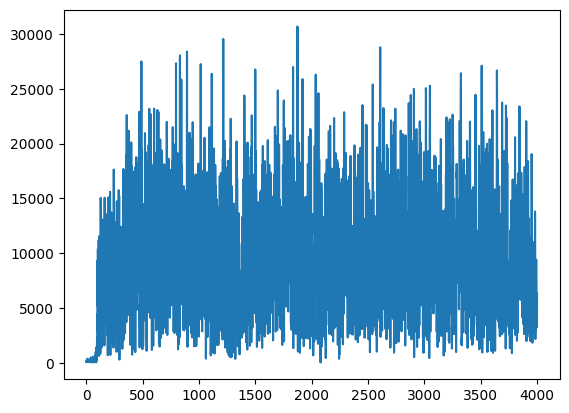

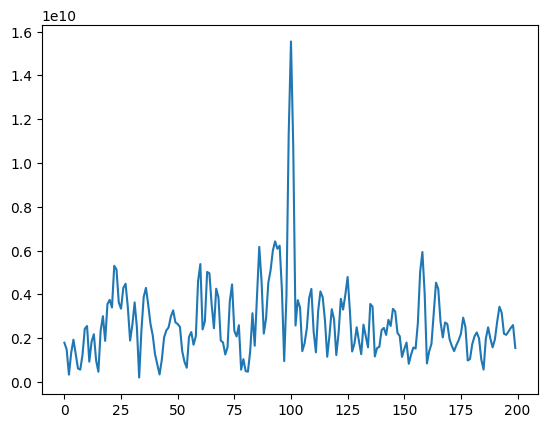

In [355]:
plt.plot(abs(pulse_compress_downsamp))
plt.figure()
idx_cell = 2
cell = corr[idx_cell, :]
idx_corr = np.argmax(abs(cell))
plt.plot(abs(cell))

print(f"phase difference between {idx_cell * pulse_len_downsamp}-{(idx_cell+1) * pulse_len_downsamp} \
and {(1+idx_cell) * pulse_len_downsamp}-{(idx_cell+2) * pulse_len_downsamp}: \
{np.arctan2(cell[idx_corr].imag, cell[idx_corr].real):.3f} rad.")

## Doppler from Phase

offset in samples: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


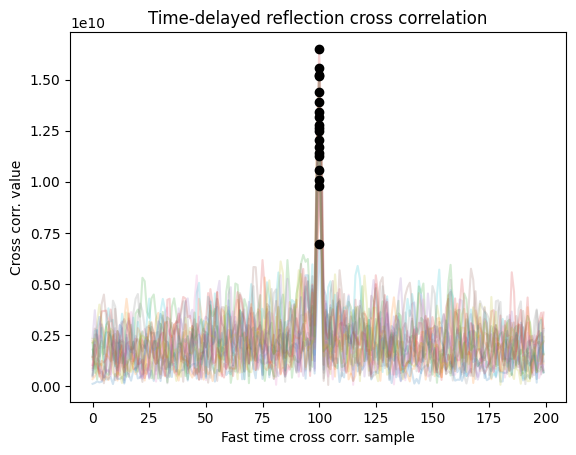

In [356]:
sig = abs(corr.T)

plt.figure()
plt.title("Time-delayed reflection cross correlation"); plt.xlabel("Fast time cross corr. sample"); plt.ylabel("Cross corr. value"); 
plt.plot(sig, alpha = 0.2, zorder = 1)
plt.scatter(corr_peak, sig[corr_peak, np.arange(len(corr))], c = 'k', zorder =2)

print(f"offset in samples: {corr_peak - corr.shape[1]//2}")

In [357]:
peak_corr = corr[np.arange(len(corr)), corr_peak]
phase_diff2 = np.arctan2(peak_corr.imag, peak_corr.real)  #np.arctan2(peak_corr.imag, peak_corr.real) # 

LoS_velocity_phase = phase_diff2 * Lambda / ((T_pulse + T_interpulse))

print(phase_diff2)

print(LoS_velocity_phase)

[ 0.00305104 -0.06852467 -0.19618327  0.06957842  0.28356316  0.26370885
  0.14414035  0.09825448 -0.06103025  0.11564343 -0.06577053  0.00064889
 -0.14433999 -0.05422166 -0.22313196 -0.05705349  0.10154965  0.13519945
 -0.04592251]
[   1.52552142  -34.26233701  -98.09163693   34.78920954  141.78158219
  131.85442522   72.07017264   49.1272403   -30.51512726   57.82171324
  -32.88526324    0.32444434  -72.16999481  -27.11083073 -111.56597895
  -28.52674632   50.77482701   67.59972606  -22.96125536]


## Doppler from $\Delta$ T 

In [286]:
delta_T = (corr_peak - corr.shape[-1]//2) * s

LoS_velocity_delta_T = c * delta_T / (T_pulse + T_interpulse)
LoS_velocity_delta_T_log = np.sign(LoS_velocity_delta_T) * np.log10(abs(LoS_velocity_delta_T))
LoS_velocity_delta_T_log = np.where(~ np.isfinite(LoS_velocity_delta_T_log), 0, LoS_velocity_delta_T_log) 

print(f"\nStandard deviation of Delta T: {np.std(delta_T):.3E} s \n")


Standard deviation of Delta T: 0.000E+00 s 



/var/folders/90/d6h21jb17nz43871lx63sp_141mt08/T/ipykernel_7587/2113699393.py:4: RuntimeWarning: divide by zero encountered in log10
  LoS_velocity_delta_T_log = np.sign(LoS_velocity_delta_T) * np.log10(abs(LoS_velocity_delta_T))
/var/folders/90/d6h21jb17nz43871lx63sp_141mt08/T/ipykernel_7587/2113699393.py:4: RuntimeWarning: invalid value encountered in multiply
  LoS_velocity_delta_T_log = np.sign(LoS_velocity_delta_T) * np.log10(abs(LoS_velocity_delta_T))


If we assume an error in correlation time $\Delta T = 1.5\cdot10^{-7}$ s between a pulse duration of $T_p = 1\cdot10^{-4}$ s, where the speed of light $c = 3\cdot10^{8}$ m/s, then the error in distance must be $\Delta x = c \cdot \Delta T = 3\cdot10^{8} \cdot 1.5\cdot10^{-7} =45$ m. 

Given that this change occurs over $T_p$, the velocity error of the change would be $\Delta x / T_p  = 450,000 $ m/s

## Comparison

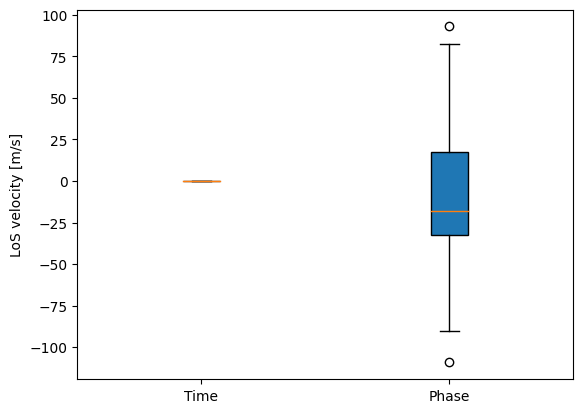

In [287]:
plt.figure()
plt.boxplot([LoS_velocity_delta_T, LoS_velocity_phase], vert=True, patch_artist=True, labels = [r'Time', 'Phase'])
_ = plt.ylabel(f"LoS velocity [m/s]")

# Testing

In [294]:
t_test = np.linspace(0,1600*np.pi, 100000, endpoint = False)
offset = 1
f_test = 1
a = np.cos(t_test * f_test + offset * np.pi) + 1j*np.sin(t_test * f_test + offset * np.pi)
b = np.cos(t_test * f_test + 0 * np.pi) + 1j*np.sin(t_test * f_test + 0 * np.pi)
# corr_test = np.correlate(a, a, 'full')
# corr_test = np.correlate(a, a, 'full')
taper = np.hamming(len(b)) #+ np.hamming(len(b))*1j 
corr_test = correlate(a, taper*b, 'full', method = 'fft')
np.arctan2(corr_test.imag[np.argmax(abs(corr_test))], corr_test.real[np.argmax(abs(corr_test))])

3.141592653589764

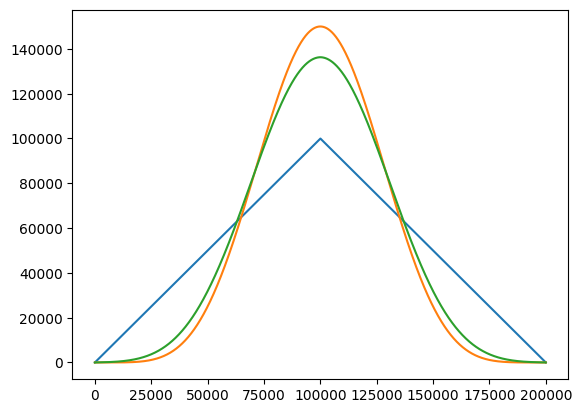

In [296]:
corr_test = correlate(b, a, 'full', method = "fft")
plt.plot(abs(corr_test))
taper = np.hanning(len(b))
corr_test = correlate(taper*b/np.mean(taper), taper*a/np.mean(taper), 'full', method = "fft")
plt.plot(abs(corr_test))
taper = np.hamming(len(b))
corr_test = correlate(taper*b/np.mean(taper), taper*a/np.mean(taper), 'full', method = "fft")
plt.plot(abs(corr_test))

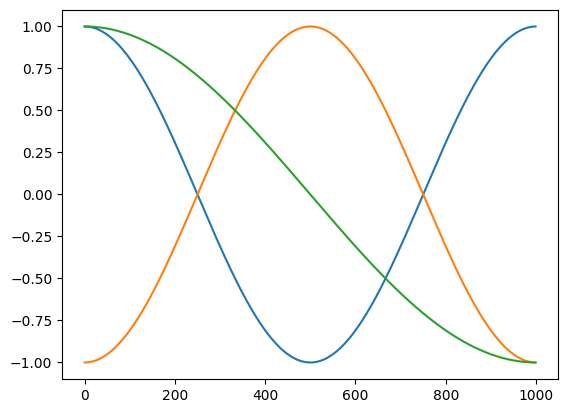

In [299]:
t_test = np.linspace(0,2*np.pi, 1000, endpoint = False)
offset = 1
f_test = 1
f_test2 = 0.5
a = np.cos(t_test * f_test) + 1j*np.sin(t_test * f_test)
b = a*np.exp(np.pi*1j) # phase shift
phase_shift = (f_test2 - f_test) * t_test
c = a * np.exp(1j * phase_shift)# frequency change

plt.plot(a)
plt.plot(b)
plt.plot(c)